In [103]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

#**Loading the data**

In [ ]:
### Loading the data

#read data
data = pd.read_csv('ex4_data.csv')

#obtain labels
labels = data.iloc[:,-1]

#check classes ratio
classes_count = labels.groupby(by = labels).count()
num_samples = sum(classes_count)
prior_true = classes_count[True]/num_samples
prior_false = classes_count[False]/num_samples


print(classes_count)
print('')
print('prior_true: ' + str(prior_true))
print('prior_false: ' + str(prior_false))

EVENT_PRIMARY
False    8207
True      539
Name: EVENT_PRIMARY, dtype: int64

prior_true: 0.06162817287903041
prior_false: 0.9383718271209696


#**Preproccess**

In [ ]:
### Cleaning and transformations

categorial_cols = ['INTENSIVE', 'RACE4']
binary_cols = ['INCLUSIONFRS','NOAGENTS','ASPIRIN','SUB_CKD','RACE_BLACK','FEMALE',
                'SUB_CVD','SUB_CLINICALCVD','SUB_SUBCLINICALCVD','SUB_SENIOR','STATIN','EVENT_PRIMARY']

#transform true false cols into binary
for binary_col in binary_cols:
  data[binary_col] = data[binary_col].astype(int)

#transform categorial data into dummies
data = pd.get_dummies(data, columns = categorial_cols, drop_first= True)

#drop columns with null falues
contains_null = data.columns[data.isnull().any()]
data = data.drop(columns = contains_null)

In [ ]:
### Scaling and class balancing

# split to train and test
y = labels
X = data.drop(columns = ['EVENT_PRIMARY'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 315328898)

# scaling the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# class balancig - generate syntetic samples with SMOTE
smote = SMOTE(random_state = 315328898)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))
x_train, y_train = x_smote, y_smote

Original dataset shape Counter({False: 5504, True: 355})
Resample dataset shape Counter({False: 5504, True: 5504})


#**Training the models**

In [104]:
# Linear model - SGDClassifier
sgd_params =  {
    'loss':['log'],
    'penalty':['elasticnet','l1','l2'],
    'alpha':np.logspace(-4, 4, 10),
    'l1_ratio':[0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2]}
sgd = GridSearchCV(estimator=SGDClassifier(), param_grid=sgd_params, scoring='roc_auc')
sgd.fit(x_train,y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'l1_ratio': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12,
                                      0.13, 0.14, 0.15, 0.2],
                         'loss': ['log'],
                         'penalty': ['elasticnet', 'l1', 'l2']},
             scoring='roc_auc')

In [105]:
# Linear model - SGDClassifier - RESULTS
print('Grid result:')
print(sgd.best_params_)
print('Score for train:')
print(sgd.best_score_)
print('Score for test:')
y_pred_sgd = sgd.predict(x_test)
print(accuracy_score(y_test, y_pred_sgd))

Grid result:
{'alpha': 0.005994842503189409, 'l1_ratio': 0.15, 'loss': 'log', 'penalty': 'elasticnet'}
Score for train:
0.7032224099348661
Score for test:
0.6647038448216142


In [ ]:
# Ensemble model - RandomForest

rf_params = {'n_estimators': (50, 100, 200, 300), 'criterion': ('gini', 'entropy')
            ,'max_depth': (None, 5, 10, 15, 20), 'min_samples_split': (2,5,10,15),'max_features': ('auto', 'sqrt', 'log2')}
rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='roc_auc')
rf.fit(x_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (None, 5, 10, 15, 20),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_split': (2, 5, 10, 15),
                         'n_estimators': (50, 100, 200, 300)},
             scoring='roc_auc')

In [89]:
# Ensemble model - RandomForest - RESULTS
print('Grid result:')
print(rf.best_params_)
print('Score for train:')
print(rf.best_score_)
print('Score for test:')
y_pred_rf = rf.predict(x_test)
print(accuracy_score(y_test, y_pred_rf))

Grid result:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 300}
Score for train:
0.9982005017769705
Score for test:
0.9338413578108763


In [ ]:
# DL model - Multilayered Perceptron
mlp_params = {'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive')}
mlp = GridSearchCV(estimator=MLPClassifier(), param_grid=mlp_params, scoring='roc_auc')
mlp.fit(x_train, y_train)

In [93]:
# DL model - Multilayered Perceptron - RESULTS
print('Grid result:')
print(mlp.best_params_)
print('Score for train:')
print(mlp.best_score_)
print('Score for test:')
y_pred_mlp = mlp.predict(x_test)
print(accuracy_score(y_test, y_pred_mlp))

Grid result:
{'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}
Score for train:
0.9901044085773055
Score for test:
0.8811915483200554


#**Comparison and Evaluation**

In [115]:
def evaluate(grid,x_test,y_test):
   prediction = grid.predict(x_test)
   accuracy = accuracy_score(y_test,prediction)
   y = grid.predict_proba(x_test,)[:,1]
   false_positive_ratio , true_positive_ratio , treshold = metrics.roc_curve(y_test,y)
   auc = metrics.auc(false_positive_ratio, true_positive_ratio)
   f1 = metrics.f1_score(y_test, prediction)
   print(f'Accuracy(test) : {accuracy}\nAUC: {auc}\nF1 Score: {f1}\n')
   print(metrics.classification_report(y_test, prediction))

def plot_data(clf, x_test, y_test):
  pred = clf.predict(x_test)
  y_score = clf.predict_proba(x_test)[:, 1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
  auc= metrics.auc(fpr, tpr)
  return fpr, tpr, auc

In [116]:
print('Linear Classifier - SGDC - Evaluation')
evaluate(sgd, x_test, y_test)
print('-'*55)
print('Ensemble Classifier - RF - Evaluation')
evaluate(rf, x_test, y_test)
print('-'*55)
print('DL Classifier - MLP - Evaluation')
evaluate(mlp, x_test, y_test)

Linear Classifier - SGDC - Evaluation
Accuracy(test) : 0.6647038448216142
AUC: 0.7073179558944168
F1 Score: 0.2

              precision    recall  f1-score   support

       False       0.97      0.67      0.79      2703
        True       0.12      0.66      0.20       184

    accuracy                           0.66      2887
   macro avg       0.54      0.66      0.49      2887
weighted avg       0.91      0.66      0.75      2887

-------------------------------------------------------
Ensemble Classifier - RF - Evaluation
Accuracy(test) : 0.9338413578108763
AUC: 0.6905129566182502
F1 Score: 0.06829268292682927

              precision    recall  f1-score   support

       False       0.94      0.99      0.97      2703
        True       0.33      0.04      0.07       184

    accuracy                           0.93      2887
   macro avg       0.64      0.52      0.52      2887
weighted avg       0.90      0.93      0.91      2887

------------------------------------------------

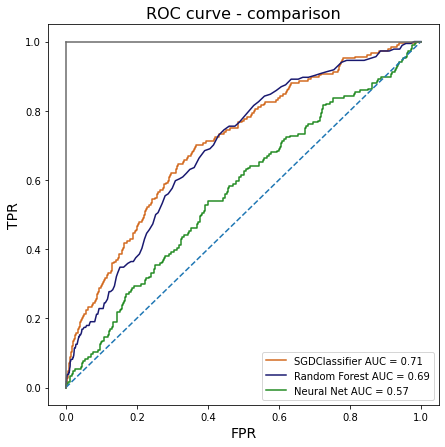

In [135]:
# ROC PLOT
# data
fpr_sgd, tpr_sgd, auc_sgd = plot_data(sgd, x_test, y_test)
fpr_rf, tpr_rf, auc_rf = plot_data(rf, x_test, y_test)
fpr_mlp, tpr_mlp, auc_mlp = plot_data(mlp, x_test, y_test)

# plot
plt.subplots(1, figsize=(7, 7))
plt.title('ROC curve - comparison', fontsize = 16)
plt.plot(fpr_sgd, tpr_sgd, 'chocolate', label='SGDClassifier AUC = %0.2f' % auc_sgd)
plt.plot(fpr_rf, tpr_rf, 'midnightblue', label='Random Forest AUC = %0.2f' % auc_rf)
plt.plot(fpr_mlp, tpr_mlp, 'forestgreen', label='Neural Net AUC = %0.2f' % auc_mlp)
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.legend(loc='lower right')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c='dimgray'), plt.plot([1, 1], c='dimgray')
plt.show()

#**Open Question's Answers**
1. For each model, does the model overfits?
**Answer**: \
as you csan see, we printed for each model its accuracy over both training and testing sets. As we learned in class we treat significant difference between accuracy scores over train and test data as overfit. \
SDG - very small difference (4%), no overfit. \
RF and MLP - here the difference is more significant (7% and 11%), plus both model's accuracy over train data is almost the global maximum. These sympthoms may suggest overfit. 
But after taking in consideration both the good results over the training set and the fact that we used cross validation we think all in all theres no overfit.

2. In the DL model, what's the effect of batch size? In general, and do you see this effect in the current task?
**Answer**: \
The effect of batch size in DL models is the updates of the gradient.
Large batch size means the model makes very large gradient updates and very small gradient updates. The size of the update depends heavily on which particular samples are drawn from the dataset. On the other hand using small batch size means the model makes updates that are all about the same size.\
We dont see much of this effect in our task, we used gridsearch for optimizaion which saved us the trouble of diving into manual testing.


#**Summerize and Explanations**
We chose to use SDG, RF and MLP as our classifiers. \
SDG - we learned about it in class and havent got the chance to use this specific implementation so we wanted to try it. \
RF - we used it in one of the labs and it showed impressive results, so we chose to use it here.
MLP - we werent present in the lab that talked about it, wanted to test it according to the theoretical material at the lectures.

Configurations and other decisions: \
* Cleaning and preprocess - we transformed categorail data into dummy variables and dropped one column that had null values.
* Scaling - we used standart scaler in order to normalize the data.
* SMOTE - we noticed the data is very unbalanced as we displayed to you earlier. After som time on google we decided to use smote to generate syntetic examples in order to balance the training set. 
* Evaluation - we calculated some Accuracy, AUC and F1 scores. plus we used the report function inorder to display som raw measures of the performence. \
For a visual comparisson we chose to display the ROC curves and the AUC value for each classifier. we think that this visualization display in a good way a comparisson between the classifiers, as we also saw in the practice sessions.
